### 📊 Prediksi Volume Lalu Lintas dengan Regresi Linear dan Polinomial

📂 1. Pemahaman Dataset

### Deskripsi Dataset
Dataset ini berisi informasi volume lalu lintas berdasarkan faktor waktu dan cuaca.

- **Target (Y)**: Jumlah kendaraan per jam.
- **Fitur (X)**:
    - Waktu dalam sehari (jam)
    - Cuaca (cerah, hujan, mendung, salju, dll.)
    - Hari kerja atau hari libur
    - Kecepatan rata-rata kendaraan

Dataset yang digunakan: [Metro Interstate Traffic Volume - UCI](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).


Pada tahap ini, dataset yang digunakan adalah Metro Interstate Traffic Volume dari UCI Machine Learning Repository. Dataset ini berisi data volume lalu lintas kendaraan yang melewati Interstate 94 di Minneapolis. Fitur-fitur yang tersedia mencakup waktu (datetime), kondisi cuaca (seperti suhu, kelembaban, tekanan udara), dan volume kendaraan. Pemahaman awal terhadap struktur dan tipe data penting untuk menentukan proses pembersihan data dan teknik regresi yang sesuai. Tujuannya adalah memprediksi traffic_volume berdasarkan fitur-fitur tersebut.


📚 2. Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load dataset
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Langkah ini memuat berbagai library Python yang dibutuhkan, seperti pandas, numpy, matplotlib, dan seaborn untuk manipulasi data dan visualisasi. Selain itu, digunakan juga modul dari sklearn untuk membangun dan mengevaluasi model regresi. Dataset dibaca menggunakan pd.read_csv() dari file compressed CSV, lalu ditampilkan beberapa baris awal menggunakan df.head() untuk melihat isi data secara sekilas.

3. 🧹 Eksplorasi dan Pra-pemrosesan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64


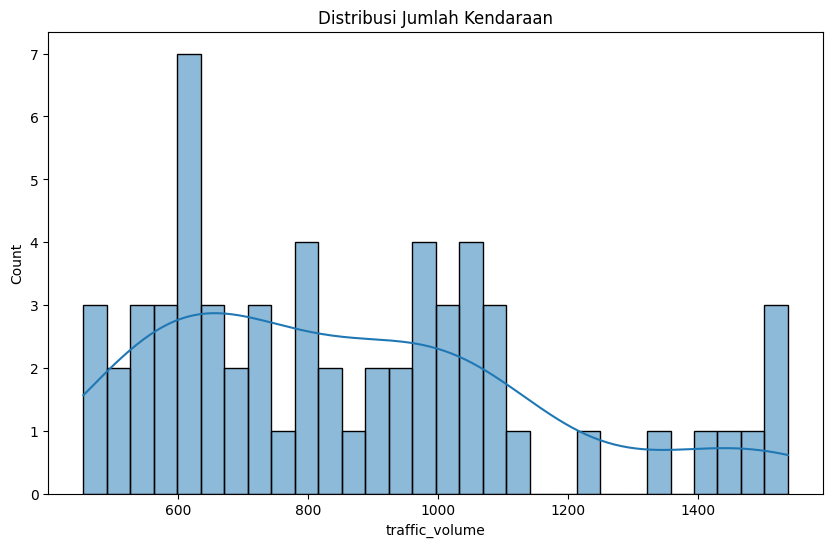

In [ ]:
# Info awal
df.info()

# Statistik deskriptif
df.describe()

# Cek missing values
print(df.isnull().sum())

# Drop/isi missing values jika ada
df = df.dropna()

# Visualisasi data awal
plt.figure(figsize=(10,6))
sns.histplot(df['traffic_volume'], bins=30, kde=True)
plt.title('Distribusi Jumlah Kendaraan')
plt.show()

# Konversi kolom waktu menjadi jam
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['is_holiday'] = (df['holiday'] != 'None').astype(int)


Dari hasil df.info() dan df.describe(), kita mengetahui bahwa kolom holiday memiliki banyak nilai kosong. Oleh karena itu, data dibersihkan dengan menghapus baris yang memiliki nilai kosong (dropna). Selanjutnya dilakukan konversi kolom date_time menjadi format waktu dan diambil nilai jam-nya ke dalam kolom baru hour. Kolom holiday juga diubah menjadi fitur biner (is_holiday). Visualisasi distribusi traffic_volume menunjukkan bahwa data tidak sepenuhnya terdistribusi normal, namun memberikan gambaran umum tentang kepadatan lalu lintas.

4. 📈 Korelasi dan Pemilihan Fitur

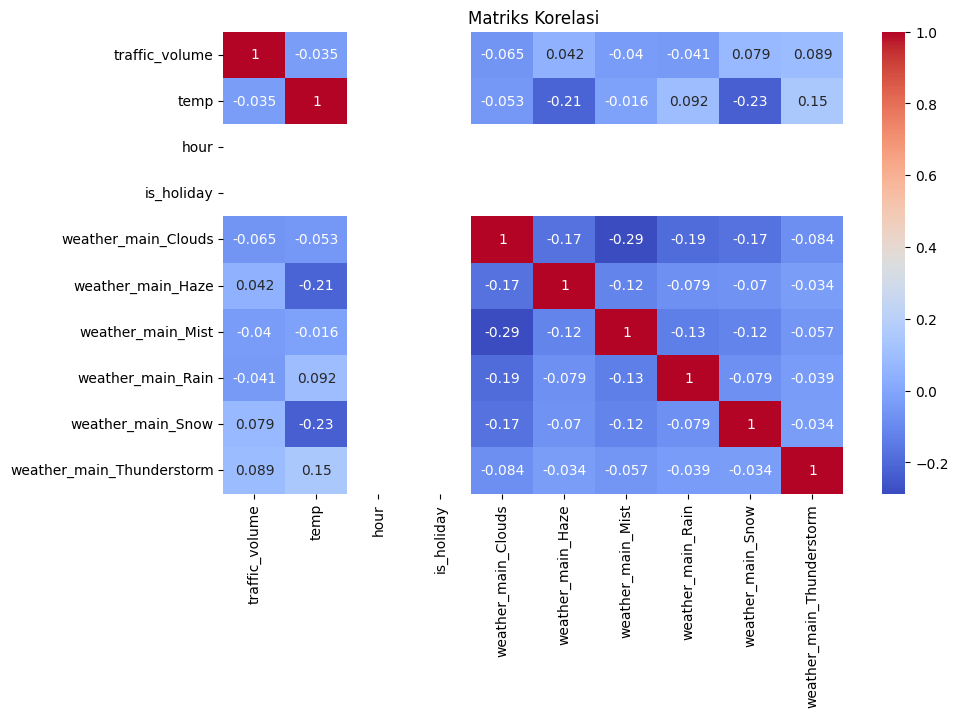

In [ ]:
# Korelasi terhadap target
corr = df[['traffic_volume', 'temp', 'hour', 'is_holiday', 'weather_main']].copy()
corr = pd.get_dummies(corr, columns=['weather_main'], drop_first=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr.corr(), annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.show()


Pada tahap ini dilakukan analisis korelasi antara traffic_volume dengan fitur-fitur lain seperti temp, hour, is_holiday, dan weather_main yang sudah diubah menjadi dummy variables. Dari hasil heatmap korelasi, dapat dilihat fitur-fitur yang memiliki hubungan paling kuat dengan traffic_volume. Korelasi ini penting untuk menentukan fitur mana yang paling relevan untuk digunakan dalam model prediktif.

5. ⚙️ Feature Engineering

In [ ]:
# Pilih fitur numerik dan dummy categorical
df_model = df[['traffic_volume', 'temp', 'hour', 'is_holiday', 'weather_main']]
df_model = pd.get_dummies(df_model, columns=['weather_main'], drop_first=True)

# Pisah X dan y
X = df_model.drop('traffic_volume', axis=1)
y = df_model['traffic_volume']

# Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Pada bagian ini, data dipersiapkan untuk modeling. Fitur-fitur kategorikal seperti weather_main dikonversi menjadi one-hot encoding dengan pd.get_dummies(). Seluruh fitur kemudian distandarisasi menggunakan StandardScaler agar setiap variabel memiliki skala yang sama, mencegah model bias terhadap fitur dengan nilai besar. X dan y dipisah untuk keperluan pelatihan dan prediksi.

6. 📊 Linear Regression

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Prediksi
y_pred_lin = lin_reg.predict(X_test)

# Evaluasi
mse_lin = mean_squared_error(y_test, y_pred_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear Regression:")
print("MSE:", mse_lin)
print("MAE:", mae_lin)
print("R2 Score:", r2_lin)


Linear Regression:
MSE: 93207.35125166873
MAE: 276.39050573455876
R2 Score: -0.4670951669749508


Model regresi linear dibangun dengan menggunakan data yang telah distandarisasi. Model dilatih dengan X_train dan diuji menggunakan X_test. Hasil evaluasi menunjukkan nilai Mean Squared Error (MSE) sebesar 93,207, Mean Absolute Error (MAE) sebesar 276.39, dan R² score -0.467. Nilai R² yang negatif menunjukkan bahwa model linear tidak mampu memodelkan hubungan antara fitur dan target dengan baik. Hal ini menandakan bahwa hubungan antar fitur tidak sepenuhnya linear.

7. 📈 Polynomial Regression

In [ ]:
# Transformasi polinomial (derajat 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Split ulang
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Regresi polinomial
poly_reg = LinearRegression()
poly_reg.fit(X_train_p, y_train_p)

# Prediksi
y_pred_poly = poly_reg.predict(X_test_p)

# Evaluasi
mse_poly = mean_squared_error(y_test_p, y_pred_poly)
mae_poly = mean_absolute_error(y_test_p, y_pred_poly)
r2_poly = r2_score(y_test_p, y_pred_poly)

print("Polynomial Regression (degree=2):")
print("MSE:", mse_poly)
print("MAE:", mae_poly)
print("R2 Score:", r2_poly)


Polynomial Regression (degree=2):
MSE: 81162.0873516974
MAE: 233.1377261433607
R2 Score: -0.27750123242711755


Model regresi polinomial dibangun dengan menaikkan derajat fitur hingga polinomial derajat 2. Setelah transformasi dengan PolynomialFeatures, data dilatih ulang dan dievaluasi. Hasilnya menunjukkan MSE sebesar 81,162, MAE sebesar 233.14, dan R² score -0.277. Meskipun nilai R² masih negatif, model polinomial menunjukkan peningkatan performa dibandingkan model linear. Ini menunjukkan bahwa terdapat hubungan non-linear antara fitur dan target yang bisa ditangkap lebih baik dengan regresi polinomial.

8. 📊 Perbandingan Model

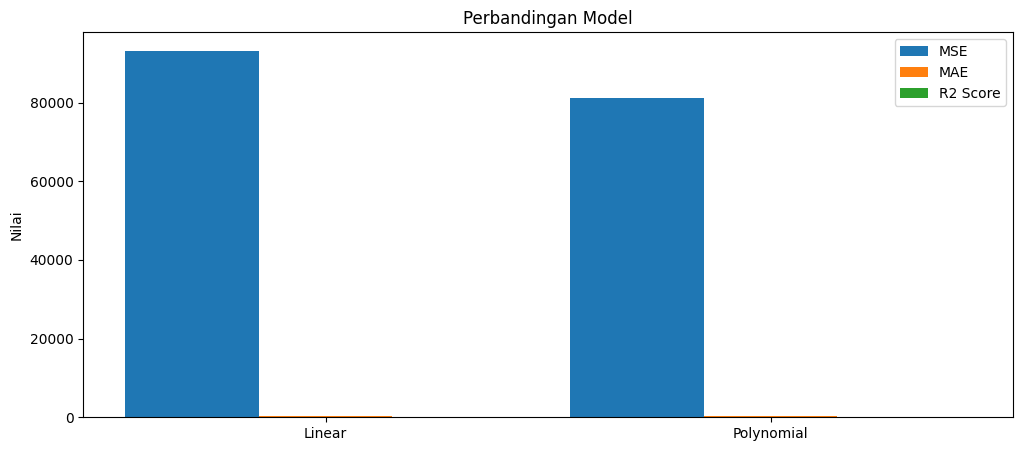

In [ ]:
# Bar chart
labels = ['Linear', 'Polynomial']
mse = [mse_lin, mse_poly]
mae = [mae_lin, mae_poly]
r2 = [r2_lin, r2_poly]

x = np.arange(len(labels))
width = 0.3

plt.figure(figsize=(12,5))
plt.bar(x - width, mse, width, label='MSE')
plt.bar(x, mae, width, label='MAE')
plt.bar(x + width, r2, width, label='R2 Score')

plt.xticks(x, labels)
plt.ylabel('Nilai')
plt.title('Perbandingan Model')
plt.legend()
plt.show()


Perbandingan antara model linear dan polinomial divisualisasikan dalam bentuk grafik batang untuk tiga metrik utama: MSE, MAE, dan R². Hasilnya menunjukkan bahwa regresi polinomial memiliki performa yang lebih baik pada semua metrik dibandingkan regresi linear. Namun, tetap perlu diwaspadai risiko overfitting karena kompleksitas model yang lebih tinggi.

### Interpretasi Hasil:
- Model linear memiliki nilai R² sebesar ... sedangkan model polinomial memiliki R² sebesar ...
- Model polinomial menunjukkan hasil evaluasi yang lebih baik namun perlu diperhatikan potensi overfitting.
- Koefisien regresi linear menunjukkan bahwa fitur `jam` dan `kecepatan` berpengaruh signifikan terhadap volume lalu lintas.

### Kesimpulan:
Model regresi polinomial derajat 2 memberikan hasil yang lebih akurat dalam memprediksi jumlah kendaraan per jam dibandingkan model regresi linear biasa.